In [90]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

In [108]:
class LinearLayer:
    # A linear layer of shape (d_in × d_out) with (tp_in × tp_out)-degree tensor
    # parallelism, dp-degree data parallelism, and bytewidth precision.
    def __init__(self, d_in, d_out, tp_in, tp_out, dp, bytewidth):
        self.d_in = d_in
        self.d_out = d_out
        self.tp_in = tp_in
        self.tp_out = tp_out
        self.dp = dp
        self.bytewidth = bytewidth

        # Derived dimensions.
        self.N = d_in*d_out                             # number of parameters
        self.d_in_local = d_in/tp_in                    # local input dimension
        self.d_out_local = d_out/tp_out                 # local output dimension
        self.N_local = self.d_in_local*self.d_out_local # local number of parameters

class ChinchillaOptimalModel:
    def __init__(self, training_flop, hidden_factor=5, bytewidth=2):
        self.training_flop = training_flop
        self.bytewidth = bytewidth
        self.hidden_factor = hidden_factor
        self.N = sqrt(training_flop/120)               # number of parameters
        self.D = 20*self.N                                # number of training tokens
        self.B = 2048*2048 * (training_flop/1e25)**(1/6)  # batch size, based on reciprocal of reducible loss
        self.L = 120 * (training_flop/1e25)**(1/6)        # number of residual blocks
        self.d = sqrt(self.N/(2*hidden_factor*self.L)) # residual dimension

class Parallelism:
    def __init__(self, pp, dp, tp_hidden, tp_residual, n_microbatches_per_batch):
        self.pp = pp
        self.dp = dp
        self.tp_hidden = tp_hidden
        self.tp_residual = tp_residual
        self.n_microbatches_per_batch = n_microbatches_per_batch

        self.n_devices = pp*dp*tp_hidden*tp_residual
    
    def __getitem__(self, key):
        return Parallelism(self.pp[key], self.dp[key], self.tp_hidden[key], self.tp_residual[key], self.n_microbatches_per_batch[key])

class Device:
    def __init__(self, name, flop_per_sec_8bit, global_Bps, net_Bps,
                 base_util=0.8, network_reduction=True, max_n_devices=15e6):
        self.name = name
        self.flop_per_sec_8bit = flop_per_sec_8bit
        self.global_Bps = global_Bps
        self.net_Bps = net_Bps
        self.base_util = base_util
        self.network_reduction = network_reduction
        self.max_n_devices = max_n_devices

    def __repr__(self):
        return self.name
    
    def all_reduce_communication(self, n, p):
        # The number of words this device has to send or receive to participate
        # in an all-reduce of a vector of local size n, with p - 1 other
        # devices.
        if self.network_reduction:
            # If p > 1, in this case a device on the network fabric does the
            # actual reduction and broadcast and we only need to transmit and
            # receive n words.
            #
            # We use a smooth underestimate of this: 2(p-1)n/p.
            return 2*(p - 1)*n/p
            # return (p > 1)*(2*n)
        else:
            # In this case we assume a bandwidth-optimal reduce-scatter +
            # multicast communication pattern, where each device is responsible
            # for reducing n/p words:
            #
            #  Step 1. Transmit p - 1 parts of size n/p to the devices
            #          responsible for reducing those parts.
            #
            #  Step 2. Receive p - 1 copies of the part of size n/p that I'm
            #          responsible for reducing from my peers.
            #
            #  Step 3. Reduce the p copies of my part and multicast the result
            #          to my peers (optimistically assumed to be free for
            #          simplicity).
            #
            #  Step 4. Receive p - 1 parts of size n/p that my peers were
            #          responsible for reducing.
            return 3*(p - 1)*n/p

    def linear_layer_fwd_bwd_secs(self, lin_layer, b):
        # Determine the time to compute a forward and backward pass through
        # lin_layer on a microbatch of b tokens. We take into account the time
        # of tensor FLOP, global memory IO, and tensor-parallel all-reduce
        # communication.
        #
        # Some assumptions (all "optimistic"):
        #  - Data movement and computation are fully overlappable, via the
        #    mechanism of multiple microbatches simultaneously in flight.
        #
        #  - Pipeline-parallel communication time is negligible (though deep
        #    pipelines may cause a bubble, which is modeled elsewhere).
        #
        #  - Pointwise operations such as activation functions and
        #    normalizations are negligible. So is attention and any
        #    communication it requires.
        #
        #  - b/dp is substantially smaller than d_in/tp_in and d_out/tp_out,
        #    where dp is the data parallel degree, tp_in is the input tensor
        #    parallel degree, and tp_out is the output tensor parallel degree.
        #    This is because this tends to be communication-optimal due to the
        #    significant communication costs of tensor parallelism compared to
        #    data parallelism. This in turn has a few implications:
        #
        #     1. The input and output matrix tends to be quite rectangular,
        #        which puts the on-chip data movement bottleneck at global
        #        memory rather than shared memory banks, L2 cache, or the
        #        SM-to-SM DSMEM network. This is because the SM- and warp-level
        #        tiles can still be large and approximately square-shaped, which
        #        removes these levels of the memory hierarchy as a bottleneck,
        #        however there isn't freedom to do this at the global level.
        #        Thus we do not model data movement on-chip except to/from
        #        global memory.
        #
        #     2. We treat global memory IO of activations as negligible. (We
        #        also assume activations fit in global memory and don't need to
        #        be recomputed during the backward pass.) However, we assume
        #        weights and their gradients cannot fit in L2 cache, such that
        #        global memory IO is required each time they're accessed.
        #
        #  - The all-reduce communication pattern is a bandwidth-optimal
        #    reduce-scatter followed by a multicast, and we treat the multicast
        #    transmission as free for simplicity.
        #
        # We also don't worry about whether our parallelism degrees divide the
        # tensor dimensions.
        d_in_local, d_out_local = lin_layer.d_in_local, lin_layer.d_out_local
        N_local = lin_layer.N_local
        tp_in, tp_out, dp = lin_layer.tp_in, lin_layer.tp_out, lin_layer.dp
        bytewidth = lin_layer.bytewidth
        b_local = b/dp

        flop, global_io, net_io = 0, 0, 0

        # Forward pass.
        global_io += N_local                                                   # Read weights.
        flop      += 2*N_local*b_local                                         # Compute output activations: Y = WX.
        net_io    += self.all_reduce_communication(d_out_local*b_local, tp_in) # All-reduce activations.

        # Backward pass (weight gradients).
        flop      += 2*N_local*b_local                                         # Compute weight gradients: ∂L/∂W = (∂L/∂Y)X^T.
        global_io += 2*N_local                                                 # Accumulate weight gradients (read + write).
        # Note: On the gradient accumulation step for the first microbatch,
        # we're overcounting global IO because technically there's no read
        # required. This is made up for by our ignoring of activation global IO
        # (e.g. during all-reduce or reloading in the backward pass), which
        # *across the whole batch* is greater than a single weight gradient
        # read. (It's also "optimistic" to distribute this cost evenly across
        # all the microbatches, since that provides better overlapping
        # opportunities.)
    
        # Backward pass (activation gradients).
        global_io += N_local                                                   # Read weights.
        flop      += 2*N_local*b_local                                         # Compute input gradients: ∂L/∂X = W^T(∂L/∂Y).
        net_io    += self.all_reduce_communication(d_in_local*b_local, tp_out) # All-reduce input gradients.

        # Total time for each type of operation. (base_util due to thermal
        # throttling is presumed to affect FLOP/s and global memory B/s, but not
        # net B/s).
        flop_secs = (flop*bytewidth)/(self.base_util*self.flop_per_sec_8bit)
        global_io_secs = (global_io*bytewidth)/(self.base_util*self.global_Bps)
        net_io_secs = (net_io*bytewidth)/self.net_Bps
        return make_interval_array(flop_secs, global_io_secs, net_io_secs)

    def linear_layer_end_of_batch_secs(self, lin_layer):
        # Determine the time for the end-of-batch gradient all-reduce (we assume
        # the optimizer step itself is negligible).
        io = self.all_reduce_communication(lin_layer.N_local, lin_layer.dp)
        global_io_secs = (io*lin_layer.bytewidth)/(self.base_util*self.global_Bps)
        net_io_secs = (io*lin_layer.bytewidth)/self.net_Bps
        flop_secs = global_io_secs.zeros_like()
        return make_interval_array(flop_secs, global_io_secs, net_io_secs)

    def model_batch_secs(self, model, parallelism):
        # Determine the time to train on a single batch of the given model,
        # given the provided parallelism degrees. We look at this from the
        # perspective of the first pipeline stage, which is the first to start
        # working and the last to finish.
    
        pp, dp, tp_hidden, tp_residual, n_microbatches_per_batch =\
            parallelism.pp, parallelism.dp, parallelism.tp_hidden, parallelism.tp_residual, parallelism.n_microbatches_per_batch
        # assert np.all(pp <= model.L), f'pp={pp}, L={model.L}'
        # assert np.all(pp <= n_microbatches_per_batch), f'pp={pp}, n_microbatches_per_batch={n_microbatches_per_batch}'
        residual_blocks_per_stage = model.L/pp
        linear_layers_per_stage = 2*residual_blocks_per_stage
    
        # Construct one of the linear layers for a residual block. We assume
        # combined forward+backward FLOP, global IO, and network IO is the same
        # for both layers across their forward and backward passes, which is
        # true as we're currently modeling it.
        lin_layer = LinearLayer(model.d, model.hidden_factor*model.d, tp_residual, tp_hidden, dp, model.bytewidth)

        # Determine the microbatch size and basic step times for a linear
        # layer's forward and backward pass on a single microbatch, as well as a
        # linear layer's data-parallel communication time. These are arrays of
        # the shape (3, *), where the first dimension is FLOP secs, global
        # memory IO secs, and network IO secs.
        b = model.B / n_microbatches_per_batch
        layer_microbatch_fwd_bwd_secs = self.linear_layer_fwd_bwd_secs(lin_layer, b)
        layer_dp_secs = self.linear_layer_end_of_batch_secs(lin_layer)
    
        # We assume the first layers's data-parallel communication can overlap
        # with the "boundary microbatch", defined as the backward pass of its
        # very last microbatch and the forward pass of its very first
        # microbatch. (The addition happens separately for each of the three
        # resources.)
        boundary_step_secs = layer_microbatch_fwd_bwd_secs + layer_dp_secs

        # For each of the rest of the layers handled by the first pipeline
        # stage, we assume its data-parallel communication can overlap with that
        # stage's *previous* layer's non-boundary microbatches, plus the current
        # layer's own boundary microbatch.
        sustained_dp_layers = linear_layers_per_stage - 1
        sustained_dp_secs = sustained_dp_layers*(n_microbatches_per_batch*layer_microbatch_fwd_bwd_secs + layer_dp_secs)

        # This leaves some microbatches on the first pipeline stage's last layer
        # which can't overlap with data-parallel communication.
        sustained_no_dp_steps = n_microbatches_per_batch - 1
        sustained_no_dp_secs = sustained_no_dp_steps*layer_microbatch_fwd_bwd_secs
    
        # Finally, we have some "bubble" steps when the first pipeline stage is
        # just idle but later stages are still working. Since we optimistically
        # treat pipeline-parallel communication as free, we assume maximal
        # pipeline stage interleaving of the residual blocks, so that this
        # occurs for a length of time corresponding to pp - 1 residual blocks,
        # i.e. 2(pp - 1) linear layer steps.
        pipeline_bubble_steps = 2*(pp - 1)
        pipeline_bubble_secs = pipeline_bubble_steps*layer_microbatch_fwd_bwd_secs

        # For each stage of the batch, we take the max of FLOP time, global
        # memory IO time, and network IO time.
        return boundary_step_secs.max(axis=0) + sustained_dp_secs.max(axis=0) +\
            sustained_no_dp_secs.max(axis=0) + pipeline_bubble_secs.max(axis=0),\
            (boundary_step_secs, sustained_dp_secs, sustained_no_dp_secs, pipeline_bubble_secs)

    def model_train_secs(self, model, parallelism):
        num_batches = model.D/model.B
        batch_secs, _ = self.model_batch_secs(model, parallelism)
        return num_batches*batch_secs

In [3]:
granularity = 0.025
def add_next_parallelism(device, model, par):
    par_last = par[-1]

    # Consider doubling each of the four parallelism degrees.
    pars = (np.ones((4, 4)) + granularity*np.diag([1, 1, 1, 1]))*[par_last.pp, par_last.dp, par_last.tp_hidden, par_last.tp_residual]

    # For each parallelism configuration, consider all power of 2 microbatch
    # counts between 1 and 2^22.
    idx_par, idx_mb = [x.flatten() for x in np.meshgrid(np.arange(4), np.arange(0, 23, granularity))]
    pp, dp, tp_hidden, tp_residual = pars[idx_par].T
    n_microbatches_per_batch = 2**idx_mb

    # Filter out invalid parallelism degrees.
    valid = (pp <= model.L) & (pp <= n_microbatches_per_batch)
    par2 = Parallelism(pp[valid], dp[valid], tp_hidden[valid], tp_residual[valid], n_microbatches_per_batch[valid])

    # Find the best by total training time.
    train_secs = device.model_train_secs(model, par2)
    best_idx = np.argmin(train_secs)
    # Add the best parallelism degree.
    return Parallelism(np.append(par.pp, par2.pp[best_idx]),
                       np.append(par.dp, par2.dp[best_idx]),
                       np.append(par.tp_hidden, par2.tp_hidden[best_idx]),
                       np.append(par.tp_residual, par2.tp_residual[best_idx]),
                       np.append(par.n_microbatches_per_batch, par2.n_microbatches_per_batch[best_idx]))

In [4]:
a100 = Device('A100', 623.7e12, 1555e9, 600e9)
h100 = Device('H100 SXM5', 1979e12, 3352e9, 900e9)

bw_limit = 5e9
pod_size = 32
h100_pod = Device(f'{pod_size} x H100 SXM5 {bw_limit/1e9:.1f} GB/s limit',
                  pod_size*h100.flop_per_sec_8bit,
                  pod_size*h100.global_Bps,
                  bw_limit,
                  max_n_devices=15e6/pod_size)
device = h100_pod
model = ChinchillaOptimalModel(4e26)

par = Parallelism(*np.array([1, 1, 1, 1, 1]).reshape(-1, 1))

for i in np.arange(np.log2(device.max_n_devices/par.n_devices[0])/np.log2(1 + granularity)):
    par = add_next_parallelism(device, model, par)

theoretical_flop_per_sec = par.n_devices*device.flop_per_sec_8bit/model.bytewidth
training_secs = device.model_train_secs(model, par)
actual_flop_per_sec = model.training_flop/training_secs
util = actual_flop_per_sec/theoretical_flop_per_sec

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(f'{model.training_flop} FLOP training run ({device.name} {model.bytewidth*8}-bit)')
ax.set_xlabel('Number of devices')
ax.set_ylabel('Parallelism Degrees')
ax.plot(par.n_devices, par.pp, label='PP')
ax.plot(par.n_devices, par.dp, label='DP')
ax.plot(par.n_devices, par.tp_hidden, label='TP Hidden')
ax.plot(par.n_devices, par.tp_residual, label='TP Residual')
ax.plot(par.n_devices[par.pp > 1], par.n_microbatches_per_batch[par.pp > 1], label='Microbatches')
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')

ax2 = ax.twinx()
ax2.set_ylabel('Utilization')
ax2.plot(par.n_devices, util, label='Utilization', color='black', linestyle='--', linewidth=3)
idxs = []
training_days = training_secs/86400
for u in [0.75, 0.5, 0.25, 0.1, 0.05, 0.02]:
    i = np.argmin(np.abs(util - u))
    idxs.append(i)
    ax2.annotate(f'{int(np.round(training_days[i]))} days', (par.n_devices[i], util[i]), xytext=(-5, -5),
                 textcoords='offset points', ha='right', va='top', rotation=10, fontsize=10, weight='bold')
    if np.all(util > u):
        break
ax2.plot(par.n_devices[idxs], util[idxs], 'o', color='black', markersize=10)
ax.legend(loc='center left')
ax2.legend()

ax.grid()

NameError: name 'make_interval_array' is not defined

Optimization took 2877 steps.
Best pipeline parallelism: IntervalArray(low: 53.233058207461355, high: 53.23308020059289)


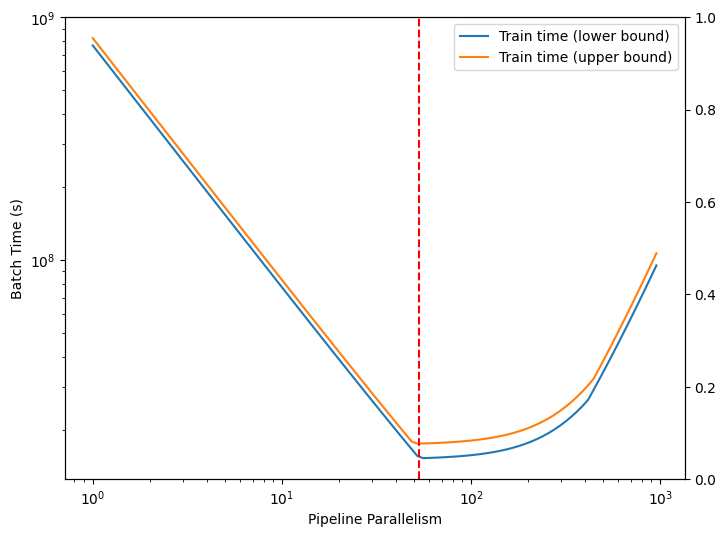

In [128]:
class IntervalArray:
    """This class represents an array of closed intervals, allowing interval
    arithmetic in a numpy-like manner. For some continuous functions, it can be
    used to efficiently find a point taking on a value provably close to the
    function's minimum, even when it is nonconvex and analytically difficult."""
    def __init__(self, low, high):
        assert np.all(low <= high)
        self.low = np.array(low)
        self.high = np.array(high)
    
    def __repr__(self):
        return f'IntervalArray(low: {self.low}, high: {self.high})'

    # Addition and Subtraction
    def __add__(self, other):
        if not isinstance(other, IntervalArray):
            other = IntervalArray(other, other)
        return IntervalArray(self.low + other.low, self.high + other.high)
    def __radd__(self, other):
        return self + other
    def __neg__(self):
        return IntervalArray(-self.high, -self.low)
    def __sub__(self, other):
        return self + (-other)
    def __rsub__(self, other):
        return -self + other

    # Multiplication and Division
    def __mul__(self, other):
        # Have to consider all possible combinations of signs.
        if not isinstance(other, IntervalArray):
            other = IntervalArray(other, other)
        return IntervalArray(np.minimum(np.minimum(self.low*other.low, self.low*other.high),
                                        np.minimum(self.high*other.low, self.high*other.high)),
                              np.maximum(np.maximum(self.low*other.low, self.low*other.high),
                                         np.maximum(self.high*other.low, self.high*other.high)))
    def __rmul__(self, other):
        return self*other
    def reciprocal(self):
        # In the case low < 0 < high, the reciprocal is [-inf, inf].
        contains_zero_neighborhood = (self.low < 0) & (0 < self.high)
        return IntervalArray(np.where(contains_zero_neighborhood, -np.inf, 1/self.high),
                             np.where(contains_zero_neighborhood, np.inf, 1/self.low))
    def __truediv__(self, other):
        if not isinstance(other, IntervalArray):
            other = IntervalArray(other, other)
        return self*other.reciprocal()
    def __rtruediv__(self, other):
        return other*self.reciprocal()

    # Exponentiation and Logarithms
    def exp(self):
        return IntervalArray(np.exp(self.low), np.exp(self.high))
    def log(self):
        assert np.all(self.low >= 0)
        return IntervalArray(np.log(self.low), np.log(self.high))
    def __pow__(self, other):
        assert np.all(self.low >= 0)
        if not isinstance(other, IntervalArray):
            other = IntervalArray(other, other)
        return IntervalArray(np.minimum(self.low**other.low, self.low**other.high),
                             np.maximum(self.high**other.low, self.high**other.high))
    def __rpow__(self, other):
        if not isinstance(other, IntervalArray):
            other = IntervalArray(other, other)
        return other**self

    # Reduction
    def sum(self, axis=None):
        return IntervalArray(np.sum(self.low, axis=axis), np.sum(self.high, axis=axis))
    def max(self, axis=None):
        return IntervalArray(np.max(self.low, axis=axis), np.max(self.high, axis=axis))
    def min(self, axis=None):
        return IntervalArray(np.min(self.low, axis=axis), np.min(self.high, axis=axis))

    # Access
    def __getitem__(self, key):
        return IntervalArray(self.low[key], self.high[key])
    def __len__(self):
        assert len(self.low) == len(self.high)
        return len(self.low)

    # Initialization
    def zeros_like(self):
        return IntervalArray(np.zeros_like(self.low), np.zeros_like(self.high))
    def ones_like(self):
        return IntervalArray(np.ones_like(self.low), np.ones_like(self.high))

    # Concatenation
    def cat(self, other):
        return IntervalArray(np.concatenate([self.low, other.low]),
                             np.concatenate([self.high, other.high]))

def make_interval_array(*args):
    """Makes a new array out of the arguments, preserving lows and highs."""
    low = []
    high = []
    any_interval_arrays = False
    for arg in args:
        if isinstance(arg, IntervalArray):
            low.append(arg.low)
            high.append(arg.high)
            any_interval_arrays = True
        else:
            low.append(arg)
            high.append(arg)
    if any_interval_arrays:
        low = np.array(np.broadcast_arrays(*low))
        high = np.array(np.broadcast_arrays(*high))
        return IntervalArray(low, high)
    else:
        return np.array([args])

bw_limit = 100e9
device = Device(f'{pod_size} x H100 SXM5 {bw_limit/1e9:.1f} GB/s limit',
                  pod_size*h100.flop_per_sec_8bit,
                  pod_size*h100.global_Bps,
                  bw_limit,
                  max_n_devices=15e6/pod_size)
model = ChinchillaOptimalModel(4e26)

def f(log2_pp):
    return device.model_train_secs(model, Parallelism(2**log2_pp, 2**(10-log2_pp), 1, 1, 1024)).log()

def optimize_over_interval(f, interval_array, tol=1e-3, max_steps=1e6, steps=0):
    while True:
        obj = f(interval_array)
        steps += len(interval_array)
        if obj.high.min() - obj.low.min() <= tol or steps >= max_steps:
            print(f'Optimization took {steps} steps.')
            return interval_array[obj.high.argmin()]
        candidates = interval_array[obj.low <= obj.high.min()]
        midpoint = (candidates.low + candidates.high)/2
        lowhalf = IntervalArray(candidates.low, midpoint)
        highhalf = IntervalArray(midpoint, candidates.high)
        interval_array = lowhalf.cat(highhalf)

best = optimize_over_interval(f, IntervalArray([0.], [10]), tol=1e-6)
print(f'Best pipeline parallelism: {2**best}')

granularity = 0.1
n_devices = 1024
log2_pp = IntervalArray(np.arange(0, np.log2(n_devices), granularity),
                        np.arange(0, np.log2(n_devices), granularity)+granularity)
obj = f(log2_pp)
pp = (2**log2_pp).low

fig, ax = plt.subplots(figsize=(8, 6))
ax2 = ax.twinx()
ax.plot(pp, np.exp(obj.low), label='Train time (lower bound)')
ax.plot(pp, np.exp(obj.high), label='Train time (upper bound)')
# Plot vertical dashed line at best.
ax.axvline(2**best.low, color='red', linestyle='--')
ax.set_xlabel('Pipeline Parallelism')
ax.set_ylabel('Batch Time (s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()


In [228]:
secs_per_batch = 1e7/(model.D/model.B)
secs_per_step = secs_per_batch/(2*2*model.L) # fwd + bwd, reduce + bcast
print(f'~{1e6*secs_per_step:.1f}µs per comms step')

~2393.0µs per comms step


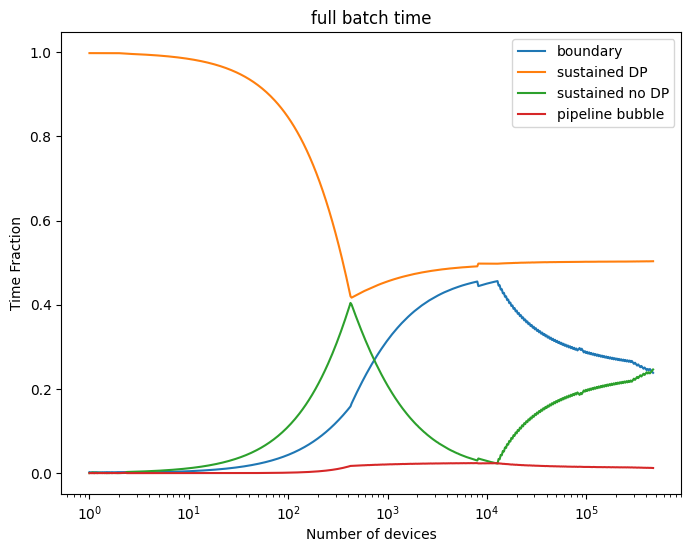

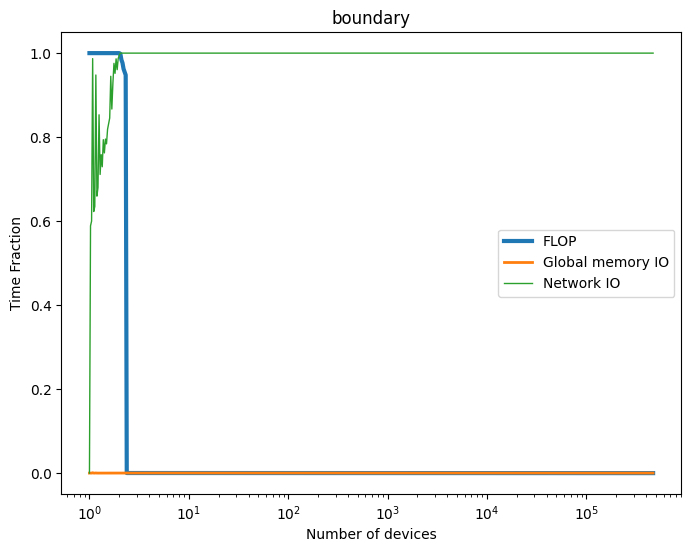

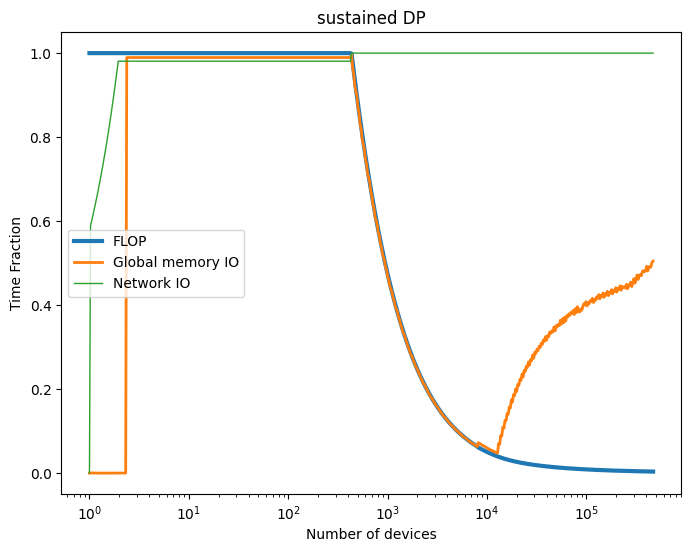

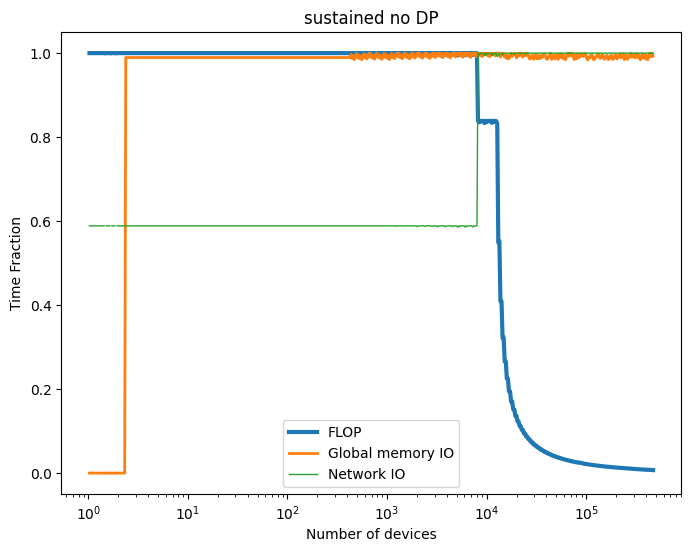

In [230]:
batch_secs, (boundary_step_secs, sustained_dp_secs, sustained_no_dp_secs, pipeline_bubble_secs) = device.model_batch_secs(model, par)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('full batch time')
ax.set_xlabel('Number of devices')
ax.set_ylabel('Time Fraction')
ax.plot(par.n_devices, boundary_step_secs.max(axis=0)/batch_secs, label='boundary')
ax.plot(par.n_devices, sustained_dp_secs.max(axis=0)/batch_secs, label='sustained DP')
ax.plot(par.n_devices, sustained_no_dp_secs.max(axis=0)/batch_secs, label='sustained no DP')
ax.plot(par.n_devices, pipeline_bubble_secs.max(axis=0)/batch_secs, label='pipeline bubble')
ax.legend()
ax.set_xscale('log')

for name, secs in (('boundary', boundary_step_secs),
                   ('sustained DP', sustained_dp_secs),
                   ('sustained no DP', sustained_no_dp_secs)):
    total_secs = secs.max(axis=0)
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(name)
    ax.set_xlabel('Number of devices')
    ax.set_ylabel('Time Fraction')
    with np.errstate(divide='ignore', invalid='ignore'):
        ax.plot(par.n_devices, secs[0]/total_secs, label='FLOP', linewidth=3)
        ax.plot(par.n_devices, secs[1]/total_secs, label='Global memory IO', linewidth=2)
        ax.plot(par.n_devices, secs[2]/total_secs, label='Network IO', linewidth=1)
    ax.legend()
    ax.set_xscale('log')